In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


# **Assignment10.0**

In [11]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/3031686df0c306c0e14c8648cc8ce328.jpg'
style_path = '/content/drive/MyDrive/Colab Notebooks/dataset/1232697907_o.jpg'

width, height = load_img(image_path).size
out_height = 400
out_width = int(width * out_height / height)

In [12]:
import numpy as np
from tensorflow.keras.applications import vgg16

def preprocess_image(image_path, img_height, img_width):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
from tensorflow.keras import backend as K

# Loss Fuction: Content Loss, Gram Matrix, Style Loss, Total Variation Loss
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination, img_height, img_width):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x, img_height, img_width):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [14]:
# Load input images
image_in = K.constant(preprocess_image(image_path, out_height, out_width))
image_style = K.constant(preprocess_image(style_path, out_height, out_width))

# Spacing for output image
combination_image = K.placeholder((1, out_height, out_width, 3))

# Combine 3 images into a single batch
input_tensor = K.concatenate([image_in,
                              image_style,
                              combination_image], axis=0)

# Load VGG16 model
# Build VGG16 with our batch of 3 images as input
# Load pre-trained imageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(3, 400, 300, 3)]        0         
                                                                 
 block1_conv1 (Conv2D)       (3, 400, 300, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 400, 300, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 200, 150, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 200, 150, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 200, 150, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (3, 100, 75, 128)         0     

In [15]:
# Loss
# Dict mapping layer names of VGG16 to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# A layer used for content loss
content_layer = 'block5_conv2'

# Layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Weights in loss components
total_variation_weight = 1e-4
style_weight = 1.0
content_weight = 0.025

# Final loss = adding all components of losses
# index 0 = image feature, 1 = image stlye, 2 = combined 0+1
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features, out_height, out_width)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image, out_height, out_width)

In [16]:
# Minimizing Loss
# Gradient Descent between loss vs. combined image
grads = K.gradients(loss, combination_image)[0]

# Fetch values of current loss and gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, out_height, out_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()



In [17]:
# Looping: style transfer
from scipy.optimize import fmin_l_bfgs_b
import imageio

iterations = 20 #10

# Use scipy-based optimization (L-BFGS) over pixels of outputted image
# To minimize the neural style loss.
x = preprocess_image(image_path, out_height, out_width)
x = x.flatten()

for i in range(iterations):
    print('Iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20) #20
    print('Current loss value:', min_val)
    # Save current outputted image
    img = x.copy().reshape((out_height, out_width, 3)) #3
    img = deprocess_image(img)

Iteration 0
Current loss value: 573989600.0
Iteration 1
Current loss value: 215926190.0
Iteration 2
Current loss value: 138823220.0
Iteration 3
Current loss value: 107017180.0
Iteration 4
Current loss value: 91403990.0
Iteration 5
Current loss value: 78893176.0
Iteration 6
Current loss value: 71673770.0
Iteration 7
Current loss value: 65718190.0
Iteration 8
Current loss value: 61318250.0
Iteration 9
Current loss value: 57386990.0
Iteration 10
Current loss value: 53625470.0
Iteration 11
Current loss value: 50209656.0
Iteration 12
Current loss value: 47196940.0
Iteration 13
Current loss value: 44605348.0
Iteration 14
Current loss value: 42223440.0
Iteration 15
Current loss value: 40455930.0
Iteration 16
Current loss value: 38864228.0
Iteration 17
Current loss value: 37352740.0
Iteration 18
Current loss value: 35979844.0
Iteration 19
Current loss value: 34879370.0


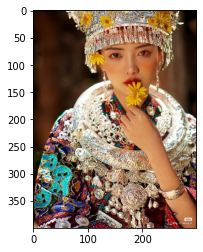

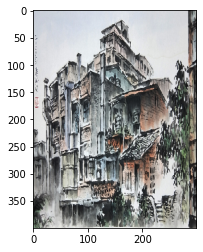

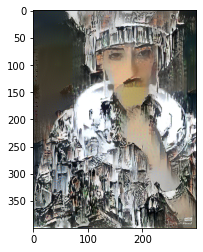

In [18]:
from matplotlib import pyplot as plt

plt.imshow(load_img(image_path, target_size=(out_height, out_width)))
plt.figure()

plt.imshow(load_img(style_path, target_size=(out_height, out_width)))
plt.figure()

plt.imshow(img)
plt.show()
